This file allows to analyze results obtained by running experiments_competing_risk.

In [1]:
import os 
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import sys

sys.path.append('../')
sys.path.append('../DeepSurvivalMachines/')
from nfg import datasets

In [9]:
df = pd.read_csv("/home/dmitrii/GitHub/NeuralFineGray/data/datasets/labels/cvd_diabetes_copd_ckd_3m_unspec/labels_ihd_hd_stroke.csv")
# for each event calculate mean time to event and standard deviation
df['mean_time_to_event'] = df.groupby('event')['time_to_event'].transform('mean')
# calculate the mean time to event and standard deviation for each event
df['std_time_to_event'] = df.groupby('event')['time_to_event'].transform('std')
# calculate the number of events for each event
df['num_events'] = df.groupby('event')['time_to_event'].transform('count')
# print stats 
print(df[['event', 'mean_time_to_event', 'std_time_to_event', 'num_events']].drop_duplicates().sort_values('event'))

      event  mean_time_to_event  std_time_to_event  num_events
1536      0         1503.952590         592.340432        1139
0         1         1019.785340         641.486991         382
2         2         1120.975096         655.303517        1044
28        3         1045.281818         640.117351         110


In [6]:
df

,eid,event,time_to_event,mean_time_to_event,std_time_to_event,num_events
0,1007079,1,1137.0,1090.388672,651.952205,1536
1,1009727,1,367.0,1090.388672,651.952205,1536
2,1013241,1,1154.0,1090.388672,651.952205,1536
3,1013997,1,592.0,1090.388672,651.952205,1536
4,1015484,1,2128.0,1090.388672,651.952205,1536
...,...,...,...,...,...,...
3016,5992177,0,1648.0,1503.952590,592.340432,1139
3017,5998769,0,1649.0,1503.952590,592.340432,1139
3018,6015621,0,1540.0,1503.952590,592.340432,1139
3019,6021657,0,1745.0,1503.952590,592.340432,1139


In [2]:
# Change this to analyze other datasets result
dataset = 'FRAMINGHAM' 
group_selection = 'sex' # For FRAMINGHAM, a more detailed analysis

In [43]:
# structural cardiac radiomics
structural_cardiac_radiomics = ['LVEDV (mL)', 'RVEDV (mL)',
       'LAV max (mL)', 'LAV min (mL)', 'RAV max (mL)',
       'RAV min (mL)', 'AAo max area (mm²)',
       'AAo min area (mm²)', 'DAo max area (mm²)', 'DAo min area (mm²)',
       'WT_AHA_1 (mm)', 'WT_AHA_2 (mm)', 'WT_AHA_3 (mm)', 'WT_AHA_4 (mm)',
       'WT_AHA_5 (mm)', 'WT_AHA_6 (mm)', 'WT_AHA_7 (mm)', 'WT_AHA_8 (mm)',
       'WT_AHA_9 (mm)', 'WT_AHA_10 (mm)', 'WT_AHA_11 (mm)', 'WT_AHA_12 (mm)',
       'WT_AHA_13 (mm)', 'WT_AHA_14 (mm)', 'WT_AHA_15 (mm)', 'WT_AHA_16 (mm)',
       'WT_Global (mm)'] + ["eid"]

df = pd.read_csv("/home/dmitrii/GitHub/NeuralFineGray/data/datasets/labels/cvd_diabetes_copd_ckd_3m_unspec/cardiac_radiomics.csv")
# take only structural_cardiac_radiomics
df = df[structural_cardiac_radiomics]
df.to_csv("/home/dmitrii/GitHub/NeuralFineGray/data/datasets/labels/cvd_diabetes_copd_ckd_3m_unspec/cardiac_radiomics_structural_only.csv", index=False)

In [63]:
dataset = "CARDIAC_WB_EMBEDDINGS+EMBEDDINGS"
group_selection = None

In [3]:
import pandas as pd
import numpy as np

# ------------------------------------------------------------------
# Parameters you might want to tweak
# ------------------------------------------------------------------
VAR_THRESHOLD   = 1e-4      #   0.0001 after min-max scaling to [0,1]
CORR_THRESHOLD  = 0.95      # |r| > 0.95   →   drop the 2nd column

# ------------------------------------------------------------------
# File locations
# ------------------------------------------------------------------
IN_FILE  = "/home/dmitrii/GitHub/NeuralFineGray/data/datasets/labels/cvd_diabetes_copd_ckd_3m_unspec/embeddings_cls.csv"
OUT_FILE = "/home/dmitrii/GitHub/NeuralFineGray/data/datasets/labels/cvd_diabetes_copd_ckd_3m_unspec/embeddings_noVarNoCorr.csv"

# ------------------------------------------------------------------
# 0)  Read raw data
# ------------------------------------------------------------------
df = pd.read_csv(IN_FILE)
print(f"Raw shape: {df.shape}")

# Select only the embedding columns  (everything that is purely numeric):
feats = df.select_dtypes(include=[np.number]).columns

# ------------------------------------------------------------------
# 1)  Low-variance filter  (after temporary min-max scaling)
# ------------------------------------------------------------------
X = df[feats].copy()

# Min-max scale to [0,1] column-wise (without touching the original df)
rng = X.max() - X.min()
rng_replaced = rng.replace(0, 1)          # avoid division by zero
X_scaled = (X - X.min()) / rng_replaced

lowvar_cols = X_scaled.var()[X_scaled.var() < VAR_THRESHOLD].index.tolist()
print(f"Dropped {len(lowvar_cols)} low-variance columns")

df = df.drop(columns=lowvar_cols)         # drop from *raw* data

# ------------------------------------------------------------------
# 2)  High-correlation filter
# ------------------------------------------------------------------
corr_matrix = df[feats.difference(lowvar_cols)].corr().abs()
upper_mask  = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper       = corr_matrix.where(upper_mask)

highcorr_cols = [c for c in upper.columns if any(upper[c] > CORR_THRESHOLD)]
print(f"Found {highcorr_cols} highly correlated columns with |r| > {CORR_THRESHOLD}")
print(f"Dropped {len(highcorr_cols)} highly correlated columns")

df = df.drop(columns=highcorr_cols)

# ------------------------------------------------------------------
# 3)  Save cleaned file
# ------------------------------------------------------------------
df.to_csv(OUT_FILE, index=False)
print(f"Clean shape: {df.shape}")
print(f"Saved  →  {OUT_FILE}")


Raw shape: (3021, 1026)
Dropped 0 low-variance columns
Found ['feature_590'] highly correlated columns with |r| > 0.95
Dropped 1 highly correlated columns


KeyboardInterrupt: 

In [64]:
path = '../Results_04.06/' # Path where the data is saved
x, t, e, cNCriates = datasets.load_dataset(dataset, path = '../', competing = True, normalize = False) # Open the data
num_events = len(np.unique(e)) - 1
print('Number of events:', num_events)

Number of rows with NaN: 339
Number of rows with NaN after filling: 0
covariate shape (2675, 2050)
duration shape (2675,)
event shape (2675,)
Number of events: 3


In [65]:
horizons = [0.25, 0.5, 0.75] # Horizons to evaluate the models
times_eval = np.quantile(t[e > 0], horizons)

In [66]:
from pycox.evaluation import EvalSurv
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc, integrated_brier_score
from metrics import truncated_concordance_td, auc_td, brier_score as bs

### Utils: The evaluatino metrics used
def evaluate(survival, e = e, t = t, groups = None, times_eval = []):
    folds = survival.iloc[:, -1].values
    survival = survival.iloc[:, :-1]
    survival.columns = pd.MultiIndex.from_frame(pd.DataFrame(index=survival.columns).reset_index().astype(float))
    
    times = survival.columns.get_level_values(1).unique()
    results = {}

    # If multiple risk, compute cause specific metrics
    for r in survival.columns.get_level_values(0).unique():
        for fold in np.arange(5):
            res = {}
            e_train, t_train = e[folds != fold], t[folds != fold]
            e_test,  t_test  = e[folds == fold], t[folds == fold]
            g_train, g_test = (None, None) if groups is None else (groups[folds != fold], groups[folds == fold])            

            survival_train = survival[folds != fold][r]
            survival_fold = survival[folds == fold][r]

            km = EvalSurv(survival_train.T, t_train, e_train != 0, censor_surv = 'km')
            test_eval = EvalSurv(survival_fold.T, t_test, e_test == int(r), censor_surv = km)

            res['Overall'] = {
                    "CIS": test_eval.concordance_td(), 
                }
            try:
                res['Overall']['BRS'] = test_eval.integrated_brier_score(times.to_numpy())
            except: pass

            km = (e_train, t_train)
            if len(times_eval) > 0:
                for te in times_eval:
                    try:
                        ci, km = truncated_concordance_td(e_test, t_test, 1 - survival_fold.values, times, te, km = km, competing_risk = int(r))
                        res[te] = {
                            "CIS": ci,
                            "BRS": bs(e_test, t_test, 1 - survival_fold.values, times, te, km = km, competing_risk = int(r))[0]}
                    except:
                        pass
                
                    for group in groups.unique() if groups is not None else []:
                        try:
                            km = (e_train[g_train == group], t_train[g_train == group])
                            res[te]["CIS_{}".format(group)] = truncated_concordance_td(e_test[g_test == group], t_test[g_test == group], 1 - survival_fold[g_test == group].values, times, te, km = km, competing_risk = int(r))[0]
                            res[te]["BRS_{}".format(group)] = bs(e_test[g_test == group], t_test[g_test == group], 1 - survival_fold[g_test == group].values, times, te, km = km, competing_risk = int(r))[0]

                            km = (e_train[g_train != group], t_train[g_train != group])
                            res[te]["Delta_CIS_{}".format(group)] = res[te]["CIS_{}".format(group)] - truncated_concordance_td(e_test[g_test != group], t_test[g_test != group], 1 - survival_fold[g_test != group].values, times, te, km = km, competing_risk = int(r))[0]
                            res[te]["Delta_BRS_{}".format(group)] = res[te]["BRS_{}".format(group)] - bs(e_test[g_test != group], t_test[g_test != group], 1 - survival_fold[g_test != group].values, times, te, km = km, competing_risk = int(r))[0]
                        
                        except:
                            pass
            results[(r, fold)] = pd.DataFrame.from_dict(res)
    results = pd.concat(results)
    results.index.set_names(['Risk', 'Fold', 'Metric'], inplace = True)

    return results

In [67]:
from experiment import Experiment

# To analyze group performance - We did this only for FRAMINGHAM
if dataset == "FRAMINGHAM":
    if group_selection == 'sex':
        groups = pd.DataFrame(x, columns = cNCriates).SEX.replace({1: 'Male', 2: 'Female'})
        print(groups.value_counts())
        for g in groups.unique():
            print("Group {} - Population {} - Outcome {:.2f}% - Censoring {:.2f}%".format(g, (groups == g).sum(), 100 * (e[groups == g] == 1).mean(),
                                                                                            100 * (e[groups == g] == 0).mean()))
    else:
        groups = pd.DataFrame(x, columns = cNCriates).AGE
        groups = pd.cut(groups, [0, 40, 50, 60, 100], labels=["<40", '40-50', "50-60", "60+"])
        print(groups.value_counts())
        for g in groups.unique().sort_values():
            print("Group {} - Population {} - Outcome {:.2f}% - Censoring {:.2f}%".format(g, (groups == g).sum(), 100 * (e[groups == g] == 2).mean(),
                                                                                        100 * (e[groups == g] == 0).mean()))
else:
    groups = None

In [68]:
# Open file and compute performance
predictions, results, models = {}, {}, {}

# 
for file_name in os.listdir(path):
    #print(file_name)
    #if ('cox' not in file_name ) and ('finegray' not in file_name): continue
    #print("_".join(file_name.split(".")[0].split("_")[0:-1]))
    if ("multi_encoders" in file_name) and (file_name.split(".")[-1] == 'csv') and ("CARDIAC" in file_name) and "TABULAR" not in file_name and "RADIOMICS" in file_name:
    #if ("_".join(file_name.split(".")[0].split("_")[0:-1]) == dataset) and file_name.split(".")[-1] == 'csv':# or file_name == 'ABDOMEN_EMBEDDINGS+RADIOMICS+TABULAR_nfg_multi_encoders.csv':
    #    print("Opening :", file_name)
    #if dataset in file_name and '.csv' in file_name: 
        model = file_name       
        #model = model[model.rindex('_') + 1: model.index('.')]
        model = "_".join(model.split("_")[2:])
        model = model[:model.index('.')]
        print("Opening :", file_name, ' - ', model)
        if 'finegray' in model or 'cox' in model:
            continue
            # Reinitialize index
            predictions[model] = pd.read_csv(path + file_name, header = [0], index_col = 0).T.ffill().T
            index = pd.DataFrame([[i, t] for i in tuple([str(ii) for ii in range(1, num_events+1)]) for t in predictions[model].columns[:100]] + [['Use', '']])
            predictions[model].columns = pd.MultiIndex.from_frame(index)
        else:
            predictions[model] = pd.read_csv(path + file_name, header = [0, 1], index_col = 0)

        results[model] = evaluate(predictions[model], groups = groups, times_eval = times_eval)

        model_file = file_name[: file_name.index('.')] + '.pickle'
        try:
            models[model] = Experiment.load(path + model_file)
        except:
            pass

# Rename
# TODO: Add your method in the list for nicer display
dict_name = {'nfg': 'NeuralFG', 'nfgcs': 'NeuralFG Non Competing', 'finegray': 'Fine Gray', 'dsm': 'DSM', 'dh': 'DeepHit', 'ds': 'DeSurv', 'coxcs': 'CS Cox',
             'nfg_multi_encoders': 'NeuralFG Multi Encoders', 'nfgcs_multi_encoders': 'NeuralFG Non Competing Multi Encoders', 'finegray_multi_encoders': 'Fine Gray Multi Encoders', 'dsm_multi_encoders': 'DSM Multi Encoders', 'dh_multi_encoders': 'DeepHit Multi Encoders', 'ds_multi_encoders': 'DeSurv Multi Encoders', 'coxcs_multi_encoders': 'CS Cox Multi Encoders'} 

results = pd.concat(results).rename(dict_name)
results.index.set_names('Model', level = 0, inplace = True)

Opening : CARDIAC_WB_EMBEDDINGS+RADIOMICS_dsm_multi_encoders.csv  -  EMBEDDINGS+RADIOMICS_dsm_multi_encoders
Opening : CARDIAC_WB_EMBEDDINGS+RADIOMICS_nfg_multi_encoders.csv  -  EMBEDDINGS+RADIOMICS_nfg_multi_encoders


In [10]:
pred_df = pd.read_csv("/home/dmitrii/GitHub/NeuralFineGray/Results_test/ABDOMEN_TABULAR_nfg.csv")

In [27]:
# PLOT predictions["dsm"]["2"] COLUMNS ARE THE TIMES AND ROWS ARE THE RISK
import matplotlib.pyplot as plt
df_1 = predictions["dh"]["2"].iloc[:10, :]
x_values = df_1.columns.astype(float)
for i, row in df_1.iterrows():
    plt.plot(x_values, row, label = e[i])
plt.legend()
plt.show()

KeyError: 'dh'

In [ ]:
# PLOT predictions["dsm"]["2"] COLUMNS ARE THE TIMES AND ROWS ARE THE RISK
from turtle import color
import matplotlib.pyplot as plt
# same as df_1 but last 10
df_1 = predictions["dh"]["1"].iloc[:100, :]
df_2 = predictions["dh"]["1"].iloc[-100:, :]
x_values = df_1.columns.astype(float)
for i, row in df_1.iterrows():
    plt.plot(x_values, row, label = e[i], color = "red")
for i, row in df_2.iterrows():
    plt.plot(x_values, row, label = e[-i], color = "blue")
plt.legend()
plt.show()

In [62]:
# Compute average performance across fold and models
table = results.groupby(['Model', 'Risk', 'Metric']).apply(lambda x:  pd.Series(["{:.3f} ({:.3f})".format(mean, std) for mean, std in zip(x.mean(), x.std())], index = x.columns))
table = table.unstack(level=-1).stack(level=0).unstack(level=-1).loc[:, ['CIS', 'BRS']]
table = table.reorder_levels(['Risk', 'Model']).sort_index(level = 0, sort_remaining = False)

table

Metric                                                  CIS                 \
                                                    Overall   569.50000001   
Risk Model                                                                   
1.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.664 (0.028)  0.688 (0.037)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.647 (0.021)  0.663 (0.031)   
2.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.674 (0.020)  0.673 (0.018)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.666 (0.015)  0.645 (0.025)   
3.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.564 (0.098)  0.534 (0.121)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.579 (0.079)  0.575 (0.145)   

Metric                                                                      \
                                              1015.00000001  1510.75000001   
Risk Model                                                                   
1.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.656 (0.022)  0.629 (0.042)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.637 (0.024)  0.615 (0.052)   
2.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.673 (0.017)  0.666 (0.020)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.660 (0.015)  0.657 (0.019)   
3.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.530 (0.115)  0.536 (0.116)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.543 (0.129)  0.545 (0.080)   

Metric                                                  BRS                 \
                                                    Overall   569.50000001   
Risk Model                                                                   
1.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.201 (0.016)  0.038 (0.007)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.237 (0.010)  0.038 (0.007)   
2.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.151 (0.004)  0.084 (0.004)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.196 (0.006)  0.084 (0.006)   
3.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.177 (0.012)  0.011 (0.003)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.178 (0.011)  0.011 (0.003)   

Metric                                                                      
                                              1015.00000001  1510.75000001  
Risk Model                                                                  
1.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.073 (0.007)  0.110 (0.003)  
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.072 (0.008)  0.110 (0.003)  
2.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.153 (0.005)  0.213 (0.013)  
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.148 (0.013)  0.205 (0.008)  
3.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.022 (0.004)  0.033 (0.004)  
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.022 (0.004)  0.033 (0.004)

In [69]:
# Compute average performance across fold and models
table = results.groupby(['Model', 'Risk', 'Metric']).apply(lambda x:  pd.Series(["{:.3f} ({:.3f})".format(mean, std) for mean, std in zip(x.mean(), x.std())], index = x.columns))
table = table.unstack(level=-1).stack(level=0).unstack(level=-1).loc[:, ['CIS', 'BRS']]
table = table.reorder_levels(['Risk', 'Model']).sort_index(level = 0, sort_remaining = False)

table

Metric                                                  CIS                 \
                                                    Overall   569.50000001   
Risk Model                                                                   
1.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.664 (0.028)  0.688 (0.037)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.647 (0.021)  0.663 (0.031)   
2.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.674 (0.020)  0.673 (0.018)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.666 (0.015)  0.645 (0.025)   
3.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.564 (0.098)  0.534 (0.121)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.579 (0.079)  0.575 (0.145)   

Metric                                                                      \
                                              1015.00000001  1510.75000001   
Risk Model                                                                   
1.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.656 (0.022)  0.629 (0.042)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.637 (0.024)  0.615 (0.052)   
2.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.673 (0.017)  0.666 (0.020)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.660 (0.015)  0.657 (0.019)   
3.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.530 (0.115)  0.536 (0.116)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.543 (0.129)  0.545 (0.080)   

Metric                                                  BRS                 \
                                                    Overall   569.50000001   
Risk Model                                                                   
1.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.201 (0.016)  0.038 (0.007)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.237 (0.010)  0.038 (0.007)   
2.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.151 (0.004)  0.084 (0.004)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.196 (0.006)  0.084 (0.006)   
3.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.177 (0.012)  0.011 (0.003)   
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.178 (0.011)  0.011 (0.003)   

Metric                                                                      
                                              1015.00000001  1510.75000001  
Risk Model                                                                  
1.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.073 (0.007)  0.110 (0.003)  
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.072 (0.008)  0.110 (0.003)  
2.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.153 (0.005)  0.213 (0.013)  
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.148 (0.013)  0.205 (0.008)  
3.0  EMBEDDINGS+RADIOMICS_dsm_multi_encoders  0.022 (0.004)  0.033 (0.004)  
     EMBEDDINGS+RADIOMICS_nfg_multi_encoders  0.022 (0.004)  0.033 (0.004)

In [15]:
# Compute average performance across fold and models
table = results.groupby(['Model', 'Risk', 'Metric']).apply(lambda x:  pd.Series(["{:.3f} ({:.3f})".format(mean, std) for mean, std in zip(x.mean(), x.std())], index = x.columns))
table = table.unstack(level=-1).stack(level=0).unstack(level=-1).loc[:, ['CIS', 'BRS']]
table = table.reorder_levels(['Risk', 'Model']).sort_index(level = 0, sort_remaining = False)

table

Metric                    CIS                                               \
                      Overall   570.00000001  1006.00000001  1519.75000001   
Risk Model                                                                   
1.0  CS Cox     0.300 (0.274)  0.300 (0.274)  0.300 (0.274)  0.300 (0.274)   
     Fine Gray  0.500 (0.000)  0.500 (0.000)  0.500 (0.000)  0.500 (0.000)   
2.0  CS Cox     0.300 (0.274)  0.300 (0.274)  0.300 (0.274)  0.300 (0.274)   
     Fine Gray  0.500 (0.000)  0.500 (0.000)  0.500 (0.000)  0.500 (0.000)   
3.0  CS Cox     0.300 (0.274)  0.300 (0.274)  0.300 (0.274)  0.300 (0.274)   
     Fine Gray  0.500 (0.000)  0.500 (0.000)  0.500 (0.000)  0.500 (0.000)   
4.0  CS Cox     0.300 (0.274)  0.300 (0.274)  0.300 (0.274)  0.300 (0.274)   
     Fine Gray  0.500 (0.000)  0.500 (0.000)  0.500 (0.000)  0.500 (0.000)   

Metric                BRS                                               
                  Overall   570.00000001  1006.00000001  1519.75000001  
Risk Model                                                              
1.0  CS Cox     nan (nan)  0.875 (0.015)  0.762 (0.004)  0.595 (0.054)  
     Fine Gray  nan (nan)  0.871 (0.012)  0.744 (0.025)  0.573 (0.052)  
2.0  CS Cox     nan (nan)  0.992 (0.004)  0.996 (0.013)  0.989 (0.044)  
     Fine Gray  nan (nan)  0.993 (0.005)  0.983 (0.020)  0.974 (0.042)  
3.0  CS Cox     nan (nan)  0.990 (0.001)  0.993 (0.010)  0.987 (0.044)  
     Fine Gray  nan (nan)  0.991 (0.004)  0.983 (0.016)  0.973 (0.043)  
4.0  CS Cox     nan (nan)  0.987 (0.003)  0.985 (0.010)  0.980 (0.041)  
     Fine Gray  nan (nan)  0.988 (0.006)  0.974 (0.017)  0.961 (0.044)

In [55]:
print(table.droplevel(0, axis = 1).loc[:,table.columns.get_level_values(1) != 'Overall'].to_latex())

\begin{tabular}{llllllll}
\toprule
 &  & 570.000000 & 1006.000000 & 1519.750000 & 570.000000 & 1006.000000 & 1519.750000 \\
Risk & Model &  &  &  &  &  &  \\
\midrule
1.000000 & DSM & 0.628 (0.021) & 0.623 (0.019) & 0.614 (0.015) & 0.110 (0.010) & 0.184 (0.005) & 0.237 (0.008) \\
\cline{1-8}
2.000000 & DSM & 0.674 (0.180) & 0.657 (0.100) & 0.698 (0.017) & 0.007 (0.002) & 0.016 (0.006) & 0.025 (0.003) \\
\cline{1-8}
3.000000 & DSM & 0.528 (0.075) & 0.637 (0.082) & 0.638 (0.093) & 0.009 (0.003) & 0.017 (0.003) & 0.027 (0.003) \\
\cline{1-8}
4.000000 & DSM & 0.608 (0.125) & 0.606 (0.076) & 0.618 (0.052) & 0.012 (0.004) & 0.026 (0.004) & 0.038 (0.004) \\
\cline{1-8}
\bottomrule
\end{tabular}



-----

# Split by age

This section is to be used for the FRAMINGHAM analysis.

In [14]:
assert (dataset == "FRAMINGHAM") or (dataset == "SYNTHETIC_COMPETING_GROUP"), "All following analysis is specific to FRAMINGHAM"

AssertionError: All following analysis is specific to FRAMINGHAM

In [ ]:
selection = ['BRS_{}'.format(group) for group in groups.unique()]

In [ ]:
table = results.groupby(['Model', 'Risk', 'Metric']).apply(lambda x: pd.Series(["{:.3f} ({:.3f})".format(mean, std) for mean, std in zip(x.mean(), x.std())], index = x.columns))
table = table.unstack(level=-1).stack(level=0).loc[['NeuralFG', 'NeuralFG Non Competing'], selection]
table = table.reorder_levels(['Risk', 'Model', None]).sort_index(level = 0, sort_remaining = False)

difference = (results.loc['NeuralFG'] - results.loc['NeuralFG Non Competing']).groupby(['Risk', 'Metric']).apply(lambda x: pd.Series(["{:.3f} ({:.3f})".format(mean, std) for mean, std in zip(x.mean(), x.std())], index = x.columns))
difference = difference.unstack(level=-1).stack(level=0).loc[:, selection]


In [ ]:
table

In [ ]:
table = table.loc[2].T.stack().reorder_levels([None, 'Metric']).sort_index(level = 0, sort_remaining = False)
table['Difference'] = difference.loc[2].stack()
table

In [ ]:
print(table.unstack().T.to_latex())

In [ ]:
print(pd.concat({"Age Group": groups, "Event": pd.Series(e)}, 1).groupby(['Age Group', 'Event']).size().unstack().to_latex())

In [ ]:
pd.concat({"Age Group": groups, "Event": pd.Series(e)}, 1).groupby(['Age Group', 'Event']).size().unstack().rename(columns = {0: 'Censoring', 1: 'Death', 2: 'CVD'})

-------

# Feature importance

Estimate the feature importance of models with and without competing risks to understand how important is to leverage this information. You need to have run the cause specific neural fine gray model (option cause_specific).

In [40]:
outcome_interest = 1 
iter = 10

In [41]:
x, t, e, cNCriates = datasets.load_dataset(dataset, competing = True, normalize = True) # Open the data
#t =  models['nfg'].__preprocess__(t)
#t = models["nfg"].__preprocess

In [24]:
cNCriates = pd.Series(cNCriates).replace({
    'SEX': 'Sex',
    'CURSMOKE': 'Smoking',
    'DIABETES': 'Diabetes',
    'BPMEDS': 'Anti-hypertensive medication',
    'educ': 'Education',
    'PREVCHD': 'Coronary Heart Disease',
    'PREVAP': 'Angina Pectoris',
    'PREVMI': ' Myocardial Infraction',
    'PREVSTRK': 'Stroke',
    'PREVHYP': 'Hypotension',
    'TOTCHOL': 'Cholesterol',
    'AGE': 'Age',
    'SYSBP': 'Systolic Blood Pressure',
    'DIABP': 'Diastolic Blood Pressure',
    'CIGPDAY': 'Number of cigarettes',
    'HEARTRTE': 'Heart rate',
    'GLUCOSE' : 'Glucose'
}).values

In [43]:
importance = {'Competing': [], 'Non Competing': []}

for fold in range(2):
    # Competing risk importance
    competing_mean, competing_std = models['nfg'].best_model[fold].feature_importance(x, t, e, iter)
    importance['Competing'].append((pd.Series(competing_mean), pd.Series(competing_std)))

    ncompeting_mean, ncompeting_std = models['nfgcs'].best_model[fold].feature_importance(x, t, e, iter)
    importance['Non Competing'].append((pd.Series(ncompeting_mean), pd.Series(ncompeting_std)))
for model in importance:
    mean, std = pd.concat([impi[0] for impi in importance[model]], axis = 1), pd.concat([impi[1] for impi in importance[model]], axis = 1)
    importance[model] = pd.concat({"Error": std.mean(1), "Mean": mean.mean(1)}, axis = 1) # Wrong error as correlation may imapct

importance = pd.concat(importance, axis = 1)
importance.index = cNCriates

100%|██████████| 10/10 [01:12<00:00,  7.24s/it]


<Axes: >

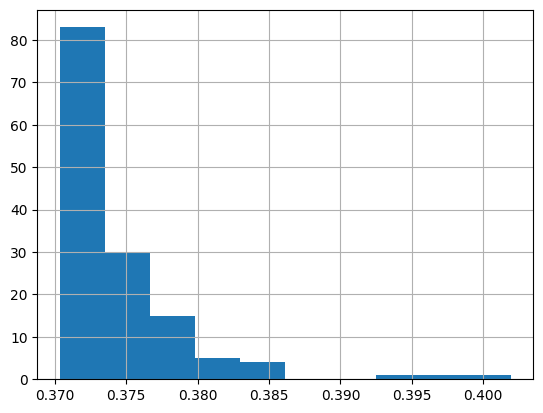

In [51]:
importance["Competing"]["Mean"].hist()

In [52]:
importance["Competing"]["Mean"] > 0.4

feature_85     False
feature_96     False
feature_137    False
feature_25     False
feature_49     False
               ...  
feature_105    False
feature_131    False
feature_52     False
feature_120    False
feature_133     True
Name: Mean, Length: 140, dtype: bool

In [44]:
sort = importance[('Competing', 'Mean')].abs().sort_values().index
importance = importance.loc[sort]

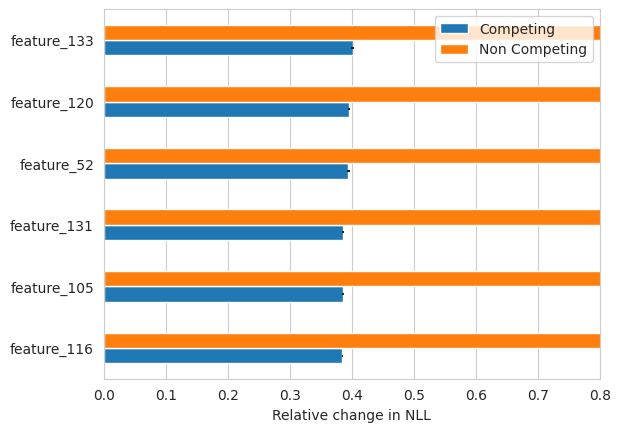

In [45]:
with sns.axes_style("whitegrid"):
    importance.iloc[-6:,[1, 3]].droplevel(1, axis = 1).plot.barh(xerr = (importance.iloc[-6:,0], importance.iloc[-6:,2]))
    plt.xlim(0, 0.8)
    plt.xlabel('Relative change in NLL')

--------

# Risk sets - Guidelines

Use with the Framingham dataset to explore how this impact the 10-year risk estimation.

In [ ]:
x, t, e, cNCriates = datasets.load_dataset(dataset, competing = True, normalize = True) # Open the data

In [ ]:
ten_year = models['nfg'].__preprocess__(3650) # To adapt if the dataset is not in dayss
labels = ["Low", "Medium", "High"]

In [ ]:
ten_year_survival = {'nfg': pd.Series('', index = predictions['nfg'].index), 'nfgcs': pd.Series('', index = predictions['nfg'].index)}
for fold in range(5):
    index = (predictions['nfg'].Use == fold).iloc[:, 0]

    # Competing risk importance
    for model in ten_year_survival:
        risks = models[model].best_model[fold].predict_risk(x[index], [ten_year], risk = 2).flatten() # Predict CVD risk
        ten_year_survival[model][index] = pd.cut(risks, [0, 0.1, 0.2, 1], labels = labels).to_numpy()

In [ ]:
selection = (groups == '50-60') | (groups == '60+')
analysisGroup = {
    'All': selection,
    'Observed event': (t <= 3650) & (e == 2) & selection,
    'No event': (t > 3650) & selection
}

for group in analysisGroup:
    confusion = pd.DataFrame(confusion_matrix(ten_year_survival['nfg'][analysisGroup[group]], ten_year_survival['nfgcs'][analysisGroup[group]], labels = labels), index = labels, columns = labels) # line represents nfg, columns single nfg
    confusion = pd.concat([confusion, confusion.sum(1).rename('Competing')], 1)
    confusion.loc['Non Competing'] = confusion.sum(0)
    print(group, confusion.to_latex())

---------

# Displaying survival curves

Displays the risk scores estimated by both models

In [ ]:
models_display = ['nfg', 'dh', 'ds', 'dsm', 'finegray', 'coxcs']

In [ ]:
np.random.seed(42)
patient_id = np.random.choice(len(predictions['nfg']), size = 5 )

In [ ]:
fig, axes = plt.subplots(len(patient_id), 2, sharex=True, sharey='row', figsize = (8, len(patient_id) * 2))
fig.supxlabel('Time (in years)')
fig.supylabel('Cumulative Incidence Functions')
plt.xlim(0, 25)

for i, id in enumerate(patient_id):
    for j, risk in enumerate(['1', '2']):
        for model in models_display:
            pred_pat = predictions[model][risk].loc[id].rename(dict_name[model])
            pred_pat.index = pred_pat.index.astype(float) / 365

            pred_pat.plot(legend = False, ax = axes[i, j])
    
        axes[i, j].grid(alpha = 0.3)
    axes[i, 0].set_ylabel(f'Patient {i + 1}')

axes[0, 0].set_title('Death')
axes[0, 1].set_title('CVD')
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

-------------